# The Effects of Interlaced Painting

In this notebook, we'll outline the effects of using the "interlacing" technique when painting a density field to a mesh. Interlacing is designed to reduce the effects of aliasing in Fourier space, which is caused by the finite sampling of the mesh. See Section 3.1 of [Sefusatti et al. 2015](https://arxiv.org/abs/1512.07295) for an introuction to the interlacing technique. Aliasing leads to spurious contributions to Fourier space statistics, and the effects become worse as one approaches the Nyquist frequency, defined as:

$$
k_\mathrm{nyq} = \pi \frac{N_\mathrm{mesh}}{L_\mathrm{box}}
$$

Interlacing is designed to remove the odd, high-frequency image multiples, thus reducing the overall aliasing contribution at $k < k_\mathrm{nyq}$.

Here, we will consider the effects on interlacing on the power spectrum when using a mesh of size $N_\mathrm{mesh}=256$, as compared to the "truth", computed using a mesh with 2x resoluton, i.e., $N_\mathrm{mesh} = 512$. We consider the effects when using Cloud in Cell (CIC) and Triangular Shaped Cloud interpoaltion methods. 

We correct the measured power spectrum for the effects of the interpolation window using equation 18 of [Jing et al. 2005](https://arxiv.org/abs/astro-ph/0409240). This amounts to dividing the power spectrum by:

$$
W^2(k_x, k_y, k_z) = \Pi_i^{x,y,z} \left [ \frac{\sin[\pi k_i / (2 k_\mathrm{nyq})]}{ \pi k_i / (2 k_\mathrm{nyq})} \right ]^p,
$$

where $p = 4,6$ for CIC and TSC windows, respectively. To accomplish this correction in nbodykit, we use the ``CompensateTSC`` and ``CompensateCIC`` functions. 

**Note**

We do not apply any additional corrections for aliasing outside of turning on interlacing. An additional approximation to correct aliasing is often used (see equation 20 of [Jing et al. 2005](https://arxiv.org/abs/astro-ph/0409240)), but we do not use that correction in order to focus on the effects of interlacing. See the functions ``CompensateTSCAliasing`` and ``CompensateCICAliasing``  for more info on these additional corrections.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import style
from scipy.interpolate import InterpolatedUnivariateSpline as spline

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

## Initalizing a Log-normal Mock

We start by generating a mock catalog of biased objects ($b_1 = 2$ ) at a redshif $z=0.55$. We use the *Planck* 2015 cosmology and the Eisenstein-Hu linear power spectrum fitting formula. We generate the catalog in a box of side length $L = 1380 \ \mathrm{Mpc}/h$ with a constant number density $\bar{n} = 3 \times 10^{-3} \ h^{3} \mathrm{Mpc}^{-3}$.


In [3]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.EHPower(cosmo, redshift)
BoxSize = 1380.
Nmesh = 256 

cat = LogNormalCatalog(Plin=Plin, nbar=3e-4, BoxSize=BoxSize, Nmesh=Nmesh, bias=2.0, seed=42)

## Generating the "Truth"

We generate the "truth" power spectrum by using a higher resolution mesh with ``Nmesh=512``, using the TSC window interpolation method. With a higher resolution mesh, the Nyquist frequency is larger, decreasing the effects of aliasing at a given $k$ value.

In [4]:
# use a high-resolution mesh to get the truth
mesh = cat.to_mesh(window='tsc', Nmesh=512, compensated=True)

# compute the 1D power of this mesh
r = FFTPower(mesh, mode='1d') 

# create a smooth interpolation 
truth = r.power
truth = spline(truth['k'], truth['power'].real - truth.attrs['shotnoise'])

## The Effects of Interlacing

In this section, we use a mesh of size $256^3$ to compute the 1D power $P(k)$ using the CIC and TSC windows and while using and not using the interlacing technique. We will then compare this $P(k)$ to the "truth", measured using the higher resolution mesh of size $512^3$.

(0.9, 1.2)

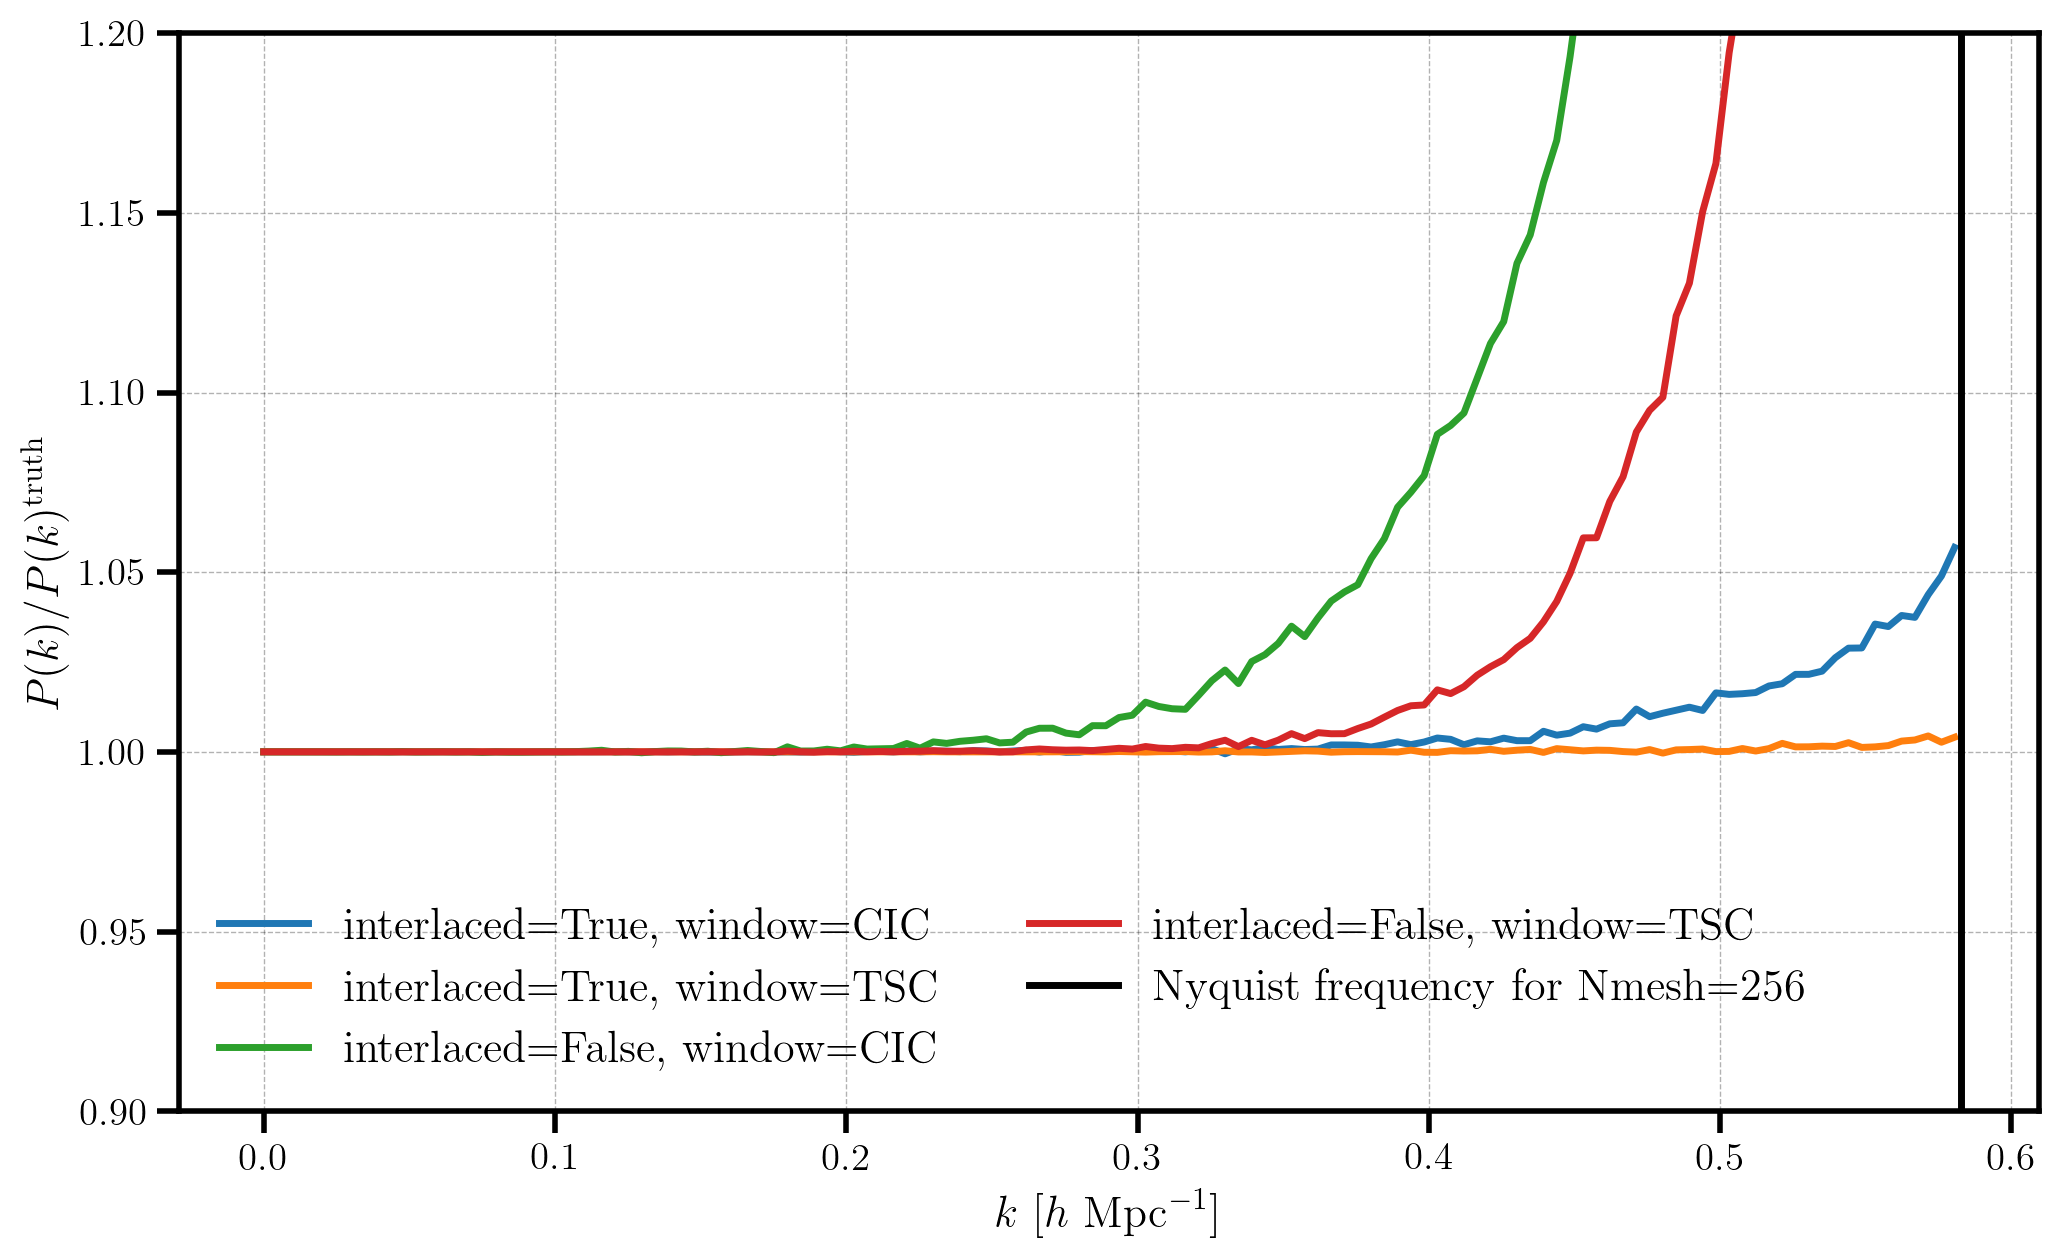

In [5]:
for interlaced in [True, False]:
    for window in ['CIC', 'TSC']:
            
        # convert catalog to a mesh with desired window and interlacing
        mesh = cat.to_mesh(Nmesh=256, window=window, compensated=False, interlaced=interlaced)

        # apply correction for the window to the mesh
        compensation = mesh.CompensateCIC if window == 'CIC' else mesh.CompensateTSC
        mesh = mesh.apply(compensation, kind='circular', mode='complex')

        # compute the 1D power P(k)
        r = FFTPower(mesh, mode='1d')
        Pk = r.power

        # compare P(k) to the hi-resolution mesh P(k)
        label = 'interlaced=%s, window=%s' %(interlaced, window)
        plt.plot(Pk['k'], (Pk['power'].real - Pk.attrs['shotnoise']) / truth(Pk['k']), label=label)
 

# plot Nyquist frequency
k_ny = numpy.pi * Nmesh / BoxSize
plt.axvline(x=k_ny, c='k', label="Nyquist frequency for Nmesh=256")

# format the axes
plt.legend(loc=0, ncol=2)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k) / P(k)^\mathrm{truth}$")
plt.ylim(0.9, 1.2)

In this figure, we see clearly see the effects of aliasing on the lower-resolution mesh results, causing the results to deviate from unity. There are two trends to note in this figure. First, TSC interpolation performs better than the CIC window, since it is a higher-order interpolation scheme. Second, for a fixed window, turning interlacing drastically reduces the contributions from aliasing. When using TSC and interlacing, $P(k)$ is recovered almost perfectly up to the Nyquist frequency.